# 第6章 图像识别与卷积神经网络

## 6.2 卷积神经网络简介

- 在全连接神经网络中，每相邻两层之间的节点都有边相连，于是一般会将每一层全连接层中的节点组织成一列，这样方便显示连接结构；而对于卷积神经网络，相邻两层之间只有部分节点相连，为了展示每一层神经元的维度，一般会将每一层卷积层的节点组织成一个三维矩阵
- 除了结构相似，卷积神经网络的输入输出以及训练流程与全连接神经网络也基本一致；卷积神经网络和全连接神经网络的唯一区别就在于神经网络中相邻两层的连接方式
- 使用全连接神经网络处理图像的最大问题在于全连接层的参数太多，这不仅会导致计算速度减慢，还很容易导致过拟合问题，所以需要一个更合理的神经网络结构来有效地减少神经网络中参数个数，卷积神经网络就可以达到这个目的

- 一个卷积神经网络主要由以下5种结构组成：
    - 输入层：三维矩阵的深度代表了图像的色彩通道（channel）
    - 卷积层：卷积层中每一个节点的输入只是上一层神经网络的一小块
    - 池化层（pooling）：进一步缩小最后全连接层中节点的个数，从而达到减少整个神经网络中参数的目的
    - 全连接层
    - softmax层

## 6.3 卷积神经网络常用结构

### 6.3.1 卷积层

- 通过zero-padding和调整步长的方式，可以调整卷积层结果矩阵的大小；在TensorFlow的实现里全0填充优先填充右下方
- 使用zero-padding，卷积层结果矩阵的大小如下：
$$out_{length}=\left \lceil in_{length}/stride_{length} \right \rceil$$
$$out_{width}=\left \lceil in_{width}/stride_{width} \right \rceil$$
- 不使用zero-padding，卷积层结果矩阵的大小如下：
$$out_{length}=\left \lceil (in_{length}-filter_{length}+1)/stride_{length} \right \rceil$$
$$out_{width}=\left \lceil (in_{width}-filter_{length}+1)/stride_{width} \right \rceil$$

- 卷积层中参数共享的好处：第一，可以使得图像上的内容不受位置的影响；第二，减少神经网络的参数数量

- TensorFlow对卷积神经网络提供了非常好的支持，以下程序实现了一个卷积层的前向传播过程

```python
import tensorflow as tf

# 前两个维度代表了过滤器的尺寸，第三个维度表示输入层的通道数，第四个维度表示feature_map的个数
filter_weight = tf.get_variable('weights', [5, 5, 3, 16], initializer=tf.truncated_normal_initializer(stddev=0.1))
# 每个feature_map共享一个bias
biases = tf.get_variable('biases', [16], initializer=tf.constant_initializer(0.1))

# 第一个参数是输入层，四维，第一维对应一个输入batch，后面三个维度对应一张图片；第二个参数是卷积层的权重；第三个参数提供的是一个长度为4的数组，但是第一维和最后一维的数字要求一定是1，因为卷积层的步长只对矩阵的长和宽有效；最后一个参数是填充（padding）的方法，SAME表示全0填充，VALID表示不填充
conv = tf.nn.conv2d(input, filter_weight, strides=[1, 1, 1, 1], padding='SAME')
bias = tf.nn.bias_add(conv, biases)
# 通过ReLU激活函数完成去线性化
actived_conv = tf.nn.relu(bias)
```

### 6.3.2 池化层

- 池化层（pooling layer）可以非常有效地缩小矩阵的尺寸，从而减少最后全连接层中的参数，使用池化层既可以加快计算速度也有防止过拟合问题的作用
- 和卷积层类似，池化层前向传播的过程也是通过移动一个类似过滤器的结构完成的，不过池化层过滤器中的计算不是节点的加权和，而是采用更加简单的最大值或者平均值运算，使用最大值操作的池化层被称之为最大池化层（max pooling），这是被使用得最多的池化层结构，使用平均值操作的池化层被称之为平均池化层（average pooling），其它池化层在实践中使用的比较少
- 与卷积层类似，池化层的过滤器也需要人工设定过滤器的尺寸、是否使用zero-padding以及过滤器移动的步长等设置

- 以下TensorFlow程序实现了最大池化层的前向传播算法
```python
# 用法和tf.nn.conv2d类似，第一个参数是输入层；第二个参数是过滤器的尺寸，虽然给出的是一个长度为4的一维数组，但是这个数组的第一个和最后一个数必须为1（常用尺寸为[1, 2, 2, 1]或[1, 3, 3, 1]）；第三个参数为步长，第一维和最后一维也只能为1；最后一个参数指定了是否使用zero-padding
pool = tf.nn.max_pool(actived_conv, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
```

- TensorFlow还提供了tf.nn.avg_pool来实现平均池化层，用法和tf.nn.max_pool一致

## 6.4 经典卷积网络模型

- 上一节介绍了卷积神经网络特有的两种网络结构——卷积层和池化层，然而通过这些网络结构任意组合得到的神经网络有无限多种，怎样的神经网络更有可能解决真实的图像处理问题呢？这一节将介绍一些经典的卷积神经网络的网络结构，通过这些经典的卷积神经网络结构可以总结出卷积神经网络结构设计的一些模式

### 6.4.1 LeNet-5模型

- LeNet-5模型总共有7层，原论文中的实现和我们接下来用TensorFlow的实现略有差别

- 通过TensorFlow训练卷积神经网络的过程和第5章中介绍的训练全连接神经网络是完全一样的，损失函数的计算、反向传播过程的实现都可以复用5.5节中给出的mnist_train.py程序，唯一的区别在于因为卷积神经网络的输入层为一个三维矩阵，所以需要调整一下输入数据的格式：

In [1]:
# 调整输入数据placeholder的格式，输入为一个四维矩阵
# 第一维表示一个batch中样例的个数；第二维和第三维表示图片的尺寸；第四维表示图片的深度，对于RGB格式的图片，深度为3
x = tf.placeholder(tf.float32, [BATCH_SIZE, mnist_inference.IMAGE_SIZE, mnist_inference.IMAGE_SIZE, mnist_inference.NUM_CHANNELS], name='x-input')

# 类似地将输入的训练数据格式调整为一个四维矩阵，并将这个调整后的数据传入sess.run过程
reshaped_xs = np.reshape(xs, (BATCH_SIZE, mnist_inference.IMAGE_SIZE, mnist_inference.IMAGE_SIZE, mnist_inference.NUM_CHANNELS))

NameError: name 'tf' is not defined

- 在调整完输入格式之后，只需要在程序mnist_inference.py中实现类似LeNet-5模型结构的前向传播过程即可，下面给出了修改后的mnist_inference.py程序

In [2]:
import tensorflow

# 配置神经网络的参数
INPUT_NODE = 784
OUTPUT_NODE = 10

IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 10

# 第一层卷积层的尺寸和深度
CONV1_DEEP = 32
CONV1_SIZE = 5
# 第二层卷积层的尺寸和深度
CONV2_DEEP = 64
CONV2_SIZE = 5
# 全连接层的节点个数
FC_SIZE = 512

# 定义卷积神经网络的前向传播过程；这里添加了一个新的参数train，用于区分训练过程和测试过程；在这个程序中将用到dropout方法，dropout可以进一步提升模型可靠性并防止过拟合，dropout过程只在训练时使用
def inference(input_tensor, train, regularizer):
    # 声明第一层卷积层的变量并实现前向传播过程；和标准的LeNet-5不大一样，这里定义的卷积层输入为28*28*1的原始MNIST图片像素，
    # 因为卷积层使用了全0填充，所以输出为28*28*32的矩阵
    with tf.variable_scope('layer1-conv1'):
        conv1_weights = tf.get_variable("weight", [CONV1_SIZE, CONV1_SIZE, NUM_CHANNELS, CONV1_DEEP], 
                                        initializer=tf.truncated_normal_initializer(stddev=0.1))
        conv1_biases = tf.get_variable("bias", [CONV1_DEEP], initializer=tf.constant_initializer(0.0))
        conv1 = tf.nn.conv2d(input_tensor, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
    
    # 实现第二层池化层的前向传播过程；这里选用最大池化层，池化层过滤器的边长为2，使用zero-padding且移动步长为2，
    # 这一层的输入是上一层的输出，也就是28*28*32的矩阵，输出为14*14*32的矩阵（这里的padding好像并没有生效）
    with tf.name_scope('layer2-pool1'):
        # 没有使用tf.get_variable，所以采用tf.name_scope
        pool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
    # 声明第三层卷积层的变量并实现前向传播过程；这一层的输入为14*14*32的矩阵，输出为14*14*64的矩阵
    with tf.variable_scope('layer3-conv2'):
        conv2_weights = tf.get_variable("weight", [CONV2_SIZE, CONV2_SIZE, CONV1_DEEP, CONV2_DEEP], 
                                       initializer=tf.truncated_normal_initializer(stddev=0.1))
        conv2_biases = tf.get_variable("bias", [CONV2_DEEP], initializer=tf.constant_initializer(0.0))
        conv2 = tf.nn.conv2d(pool1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
    
    # 实现第四层池化层的前向传播过程；这一层和第二层的结构是一样的，这一层的输入为14*14*64的矩阵，输出为7*7*64的矩阵
    with tf.name_scope('layer4-pool2'):
        pool2 = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
    # 将第四层池化层的输出转化为第五层全连接层的输入格式；第四层的输出为7*7*64的矩阵，然而第五层全连接层需要的输入格式为向量，所以在这里需要
    # 将这个7*7*64的矩阵拉直成一个向量；pool.get_shape函数可以得到第四层输出矩阵的维度而不需要手工计算；注意因为每一层神经网络的输入输出
    # 都为一个batch的矩阵，所以这里得到的维度也包含了一个batch中数据的个数
    pool_shape = pool2.get_shape().as_list()
    # 计算将矩阵拉直成向量之后的长度，这个长度就是矩阵长宽及深度的乘积；注意这里pool_shape[0]为一个batch中数据的个数
    nodes = pool_shape[1] * pool_shape[2] * pool_shape[3]
    # 通过tf.reshape函数将第四层的输出变成一个batch的向量
    reshaped = tf.reshape(pool2, [pool_shape[0], nodes])
    
    # 声明第五层全连接层的变量并实现前向传播过程；这一层的输入是拉直之后的一组向量，向量长度为3136，输出是一组长度为512的向量；
    # dropout在训练时会随机将部分节点的输出改为0，可避免过拟合问题，从而使得模型在测试数据上的效果更好；dropout一般只在全连接层而不是
    # 卷积层或池化层使用
    with tf.variable_scope('layer5-fc1'):
        fc1_weights = tf.get_variable("weight", [nodes, FC_SIZE],
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
        if regularizer != None:
            tf.add_to_collection('losses', regularizer(fc1_weights))
        fc1_biases = tf.get_variable("bias", [FC_SIZE], initializer=tf.constant_initializer(0.1))
        fc1 = tf.nn.relu(tf.matmul(reshaped, fc1_weights) + fc1_biases)
        if train: 
            fc1 = tf.nn.dropout(fc1, 0.5)
    
    # 声明第六层全连接层的变量并实现前向传播过程；这一层的输入为一组长度为512的向量，输出为一组长度为10的向量；
    # 这一层的输出通过softmax之后就得到了最后的分类结果
    with tf.variable_scope('layer6-fc2'):
        fc2_weights = tf.get_variable("weight", [FC_SIZE, NUM_LABELS], 
                                     initializer=tf.truncated_normal_initializer(stddev=0.1))
        if regularizer != None:
            tf.add_to_collection('losses', regularizer(fc2_weights))
        fc2_biases = tf.get_variable("bias", [NUM_LABELS], initializer=tf.constant_initializer(0.1))
        logit = tf.matmul(fc1, fc2_weights) + fc2_biases
    
    # 返回第六层的输出
    return logit

- 类似地修改第5章中给出的mnist_eval.py程序输入部分，就可以测试这个卷积神经网络在MNIST数据集上的正确率了

- 然而一种卷积神经网络架构不能解决所有问题，比如LeNet-5模型就无法很好地处理类似ImageNet这样比较大的图像数据集，那么如何设计卷积神经网络的架构呢？以下正则表达式公式总结了一些经典的用于图片分类问题的卷积神经网络架构：输入层 -> （卷积层+ -> 池化层?）+ -> 全连接层+；在以上公式中，“池化层?”表示没有或者一层池化层，池化层虽然可以起到减少参数防止过拟合问题，但是部分论文中也发现可以直接通过调整卷积层步长来完成，所以有些卷积神经网络中没有池化层
- 除了LeNet-5模型，2012年ImageNet ILSVRC图像分类挑战的第一名AlexNet模型、2013年ILSVRC第一名ZF Net模型以及2014年第二名VGGNet模型的架构都满足上面介绍的正则表达式
- 有了卷积神经网络的架构，那么每一层卷积层或者池化层中的配置需要如何设置呢？VGG Net中的过滤器边长一般为3或者1，在LeNet-5模型中，也使用了边长为5的过滤器，一般卷积层的过滤器边长都不会超过5，但有些卷积神经网络结构中，处理输入的卷积层中使用了边长为7甚至是11的过滤器
- 在过滤器的深度上，大部分卷积神经网络都采用逐层递增的方式；卷积层的步长一般为1，但是在有些模型中也会使用2，或者3作为步长；池化层的配置相对简单，用的最多的是最大池化层，池化层的过滤器边长一般为2或者3，步长也一般为2或者3

### 6.4.2 Inception-v3模型

- Inception结构是一种和LeNet-5结构完全不同的卷积神经网络结构，在LeNet-5模型中，不同卷积层通过串联的方式连接在一起，而Inception-v3模型中的Inception结构是将不同的卷积层通过并联的方式结合在一起

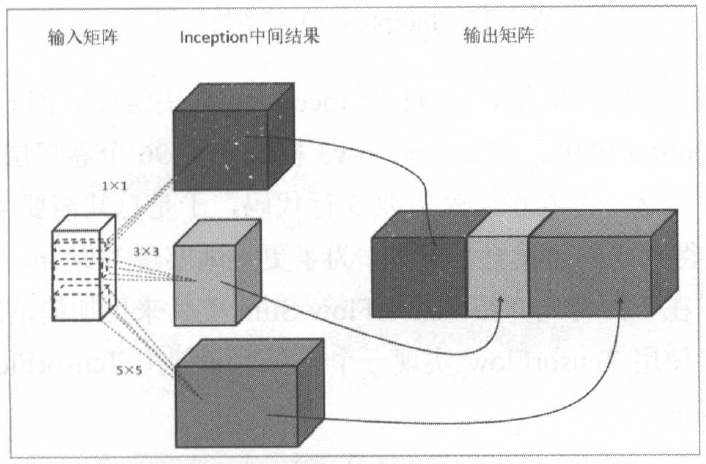
- 如上图所示，Inception模块会首先使用不同尺寸的过滤器处理输入矩阵，不同的输出矩阵代表了Inception模块中的一条计算路径，虽然过滤器的大小不同，但如果所有的过滤器都使用全0填充且步长为1，那么前向传播得到的结果矩阵的长和宽都与输入矩阵一致，这样经过不同过滤器处理的结果矩阵可以拼接成一个更深的矩阵
- 上图展示的是Inception模块的核心思想，真正在Inception-v3模型中使用的Inception模块要更加复杂多样；Inception-v3模型总共有46层，由11个Inception模块组成，有96个卷积层

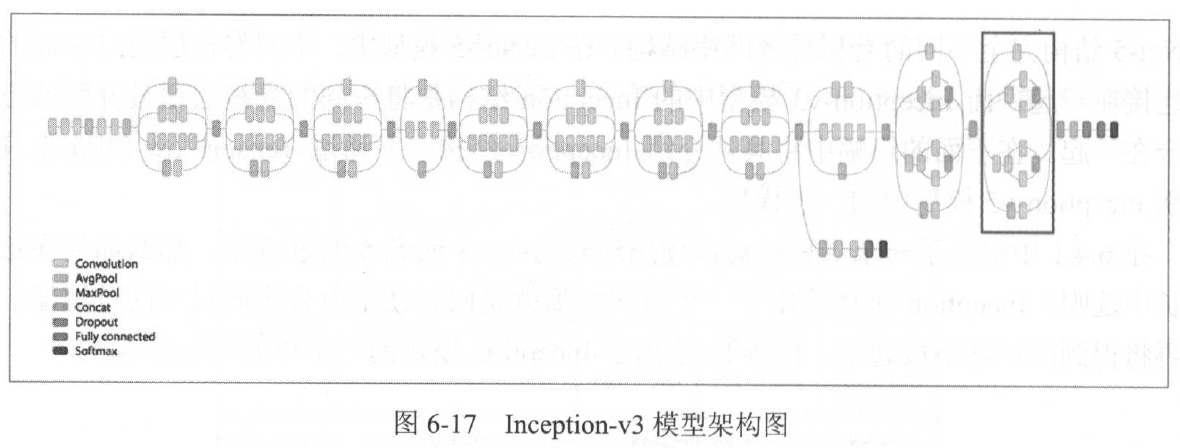

- 因为完整的Inception-v3模型比较长，所以本书中仅提供Inception-v3模型中结构相对复杂的一个Inception模块的代码实现（上图被框住的部分）

In [3]:
# 加载slim库
import tensorflow as tf
slim = tf.contrib.slim

# slim.arg_scope函数可以用于设置默认的参数取值；slim.arg_scope函数的第一个参数是一个函数列表，在这个列表中的函数将使用默认的参数取值；比如通过下面的定义，调用slim.conv2d(net, 320, [1, 1])函数时会自动加上stride=1和padding='SAME'的参数；如果在函数调用时指定了stride，那么这里设置的默认值就不会再使用，通过这种方式可以进一步减少冗余的代码
with slim.arg_scope([slim.conv2d, slim.max_pool2d, slim.avg_pool2d], stride=1, padding='SAME'):
    # 此处省略了Inception-v3模型中其它的网络结构，假设输入图片经过之前的神经网络前向传播的结果保存在变量net中
    # 为一个Inception模块声明一个统一的变量命名空间
    with tf.variable_scope('Mixed_7c'):
        # 给Inception模块中每一条路径声明一个命名空间
        with tf.variable_scope('Branch_0'):
            # 实现一个过滤器边长为1，深度为320的卷积层
            branch_0 = slim.conv2d(net, 320, [1, 1], scope='Conv2d_0a_1x1')
            
        # Inception模块中的第二条路径，这条计算路径上的结构本身也是一个Inception结构
        with tf.variable_scope('Branch_1'):
            branch_1 = slim.conv2d(net, 384, [1, 1], scope='Conv2d_0a_1x1')
            # tf.concat函数可以将多个矩阵拼接起来；tf.concat函数的第一个参数指定了拼接的维度，这里给出的"3"代表了矩阵是在深度这个维度上
            # 进行拼接
            branch_1 = tf.concat(3, [slim.conv2d(branch_1, 384, [1, 3], scope='Conv2d_0b_1x3'), 
                                    slim.conv2d(branch_1, 384, [3, 1], scope='Conv2d_0c_3x1')])
            
        # Inception模块中第三条路径，这条计算路径也是一个Inception结构
        with tf.variable_scope('Branch_2'):
            branch_2 = slim.conv2d(net, 448, [1, 1], scope='Conv2d_0a_1x1')
            branch_2 = slim.conv2d(branch_2, 384, [3, 3], scope='Conv2d_0b_3x3')
            branch_2 = tf.concat(3, [slim.conv2d(branch_2, 384, [1, 3], scope='Conv2d_0c_1x3'), 
                                    slim.conv2d(branch_2, 384, [3, 1], scope='Conv2d_0d_3x1')])
            
        # Inception模块中第四条路径
        with tf.variable_scope('Branch_3'):
            branch_3 = slim.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
            branch_3 = slim.conv2d(branch_3, 192, [1, 1], scope='Conv2d_0b_1x1')
            
        # 当前Inception模块的最后输出是由上面4个计算结果拼接得到的
        net = tf.concat(3, [branch_0, branch_1, branch_2, branch_3])


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



NameError: name 'net' is not defined

## 6.5 卷积神经网络迁移学习

### 6.5.1 迁移学习介绍

- 训练复杂的卷积神经网络需要非常多的标注数据，而且即使有海量的训练数据，要训练一个复杂的卷积神经网络也需要几天甚至几周的时间；为了解决标注数据和训练时间的问题，可以使用迁移学习
- 所谓迁移学习，就是将一个问题上训练好的模型通过简单的调整使其适用于一个新的问题；根据论文中的结论，可以保留训练好的Inception-v3模型中所有卷积层的参数，只是替换最后一层全连接层，在最后这一层全连接层之前的网络层称之为瓶颈层（bottleneck）
- 将新的图像通过训练好的卷积神经网络直到瓶颈层的过程可以看成是对图像进行特征提取的过程；在训练好的Inception-v3模型中，因为将瓶颈层的输出再通过一个单层的全连接层神经网络可以很好地区分1000种类别的图像，所以有理由认为瓶颈层输出的节点向量可以被作为任何图像的一个更加精简且表达能力更强的特征向量；于是，在新数据集上，可以直接利用这个训练好的神经网络对图像进行特征提取，然后再将提取得到的特征向量作为输入来训练一个新的单层全连接神经网络处理新的分类问题
- 一般来说，在数据量足够的情况下，迁移学习的效果不如完全重新训练，但是迁移学习所需要的训练时间和训练样本数要远远小于训练完整的模型

### 6.5.2 TensorFlow实现迁移学习

In [4]:
import glob
import os.path
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile
import tensorflow.contrib.slim as slim

# 加载通过TensorFlow-Slim定义好的Inception-v3模型
import tensorflow.contrib.slim.python.slim.nets.inception_v3 as inception_v3

# 处理好的数据文件
INPUT_DATA = '/path/to/flower_processed_data.npy'
# 保存训练好的模型的路径；这里可以将使用新数据训练得到的完整模型保存下来，如果计算资源充足，还可以在训练完最后的全连接层之后再训练所有网络层，这样可以使得新模型更加贴近新数据
TRAIN_FILE = '/path/to/save_model'
# 谷歌提供的训练好的模型文件地址
CKPT_FILE = '/path/to/inception_v3.ckpt'

# 定义训练中使用的参数
LEARNING_RATE = 0.0001
STEPS = 300
BATCH = 32
N_CLASSES = 5

# 不需要从谷歌训练好的模型中加载的参数；这里就是最后的全连接层，因为在新的问题中要重新训练这一层中的参数；这里给出的是参数的前缀
CHECKPOINT_EXCLUDE_SCOPES = 'InceptionV3/Logits,InceptionV3/AuxLogits'
# 需要训练的网络层参数名称，在fine-tuning的过程中就是最后的全连接层，这里给出的是参数的前缀
TRAINING_SCOPEs = 'InceptionV3/Logits,InceptionV3/AuxLogits'

# 获取所有需要从谷歌训练好的模型中加载的参数
def get_tuned_variables():
    exclusions = [scope.strip() for scope in CHECKPOINT_EXCLUDE_SCOPES.split(',')]
    variables_to_restore = []
    # 枚举Inception-v3模型中所有的参数，然后判断是否需要从加载列表中移除
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)
    return variables_to_restore

# 获取所有需要训练的变量列表
def get_trainable_variables():
    scopes = [scope.strip() for scope in TRAINABLE_SCOPE.split(',')]
    variables_to_train = []
    for scope in scopes:
        variables = tf.get_collection(tf.GraphKeys.TRAINANLE_VARIABLES, scope)
        variables_to_train.extend(variables)
    return variables_to_train

def main():
    # 加载预处理好的数据
    processed_data = np.load(INPUT_DATA)
    training_images = processed_data[0]
    n_training_example = len(training_images)
    training_labels = processed_data[1]
    validation_images = processed_data[2]
    validation_labels = processed_data[3]
    testing_images = processed_data[4]
    testing_labels = processed_data[5]
    
    # 定义Inception-v3的输入，images为输入图片，labels为每一张图片对应的标签
    images = tf.placeholder(tf.float32, [None, 299, 299, 3], name='input_images')
    labels = tf.placeholder(tf.int64, [None], name='labels')
    
    # 定义Inception-v3模型
    with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
        logits, _ = inception_v3.inception_v3(images, num_classes=N_CLASSES)
    # 获取需要训练的变量
    trainable_variables = get_trainable_variables()
    # 定义交叉熵损失，注意模型在定义的时候已经将正则化损失加入损失集合了
    tf.losses.softmax_cross_entropy(tf.one_hot(labels, N_CLASSES), logits, weights=1.0)
    # 定义训练过程，这里minimize的过程中指定了需要优化的变量集合
    train_step = tf.train.RMSPropOptimizer(LEARNING_RATE).minimize(tf.losses.get_total_loss())
    
    # 计算正确率
    with tf.name_scope('evaluation'):
        correct_prediction = tf.equal(tf.argmax(logits, 1), labels)
        evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # 定义加载模型的函数
    load_fn = slim.assign_from_checkpoint_fn(CKPT_FILE, get_tuned_variables(), ignore_missing_vars=True)
    
    # 定义保存新的训练好的模型的函数
    saver = tf.train.Saver()
    with tf.Session() as sess:
        # 初始化没有加载进来的变量；注意这个过程一定要在模型加载之前，否则初始化过程会将已经加载好的变量重新赋值
        init = tf.global_variables_initializer()
        sess.run(init)
        
        # 加载谷歌已经训练好的模型
        print 'Loading tuned variables from %s' % CKPT_FILE
        load_fn(sess)
        
        start = 0
        end = BATCH
        for i in range(STEPS):
            # 运行训练过程，这里不会更新全部的参数，只会更新指定的部分参数
            sess.run(train_step, feed_dict={images: training_images[start:end], labels: training_labels[start:end]})
            
            # 输出日志
            if i % 30 == 0 or i + 1 == STEPS:
                saver.save(sess, TRAIN_FILE, global_step=i)
                validation_accuracy = sess.run(evaluation_step, feed_dict={images: validation_images, 
                                                                           labels: validation_labels})
                print 'Step %d: Validation accuracy = %.1f%%' % (i, validation_accuracy * 100.0)
                
            # 因为在数据预处理的时候已经做过了打乱数据的操作，所以这里只需要顺序使用训练数据就好
            start = end
            if start == n_training_example:
                start = 0
                    
            end = start + BATCH
            if end > n_training_example:
                end = n_training_example
                    
        # 在最后的测试数据上测试正确率
        test_accuracy = sess.run(evaluation_step, feed_dict={images: testing_images, labels: testing_labels})
        print 'Final test accuracy = %.1f%%' % (test_accuracy * 100)
            
if __name__ == "__main__":
    tf.app.run()

TypeError: main() takes no arguments (1 given)